## MODELLING

In [ ]:
# Import pre-processing libraries
import pandas as pd
import numpy as np
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from xgboost import XGBClassifier


from warnings import filterwarnings
filterwarnings('ignore')



In [2]:
# Load the preprocessed data
df = pd.read_csv('NSE_2021_2024_Final.csv')
df.head()

,Unnamed: 0,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Volume,Sector,Change,Change%
0,0,2021-01-04,EGAD,Eaagads Ltd,8.2,14.0,12.5,12.5,12.5,12.5,3200.0,Agricultural,0.0,0.0
1,1,2021-01-04,KUKZ,Kakuzi Plc,300.0,397.0,365.0,365.0,365.0,365.0,0.0,Agricultural,0.0,0.0
2,2,2021-01-04,KAPC,Kapchorua Tea Kenya Plc,59.0,90.0,78.0,78.0,78.0,78.0,0.0,Agricultural,0.0,0.0
3,3,2021-01-04,LIMT,Limuru Tea Plc,360.0,475.0,360.0,360.0,360.0,360.0,100.0,Agricultural,0.0,0.0
4,4,2021-01-04,SASN,Sasini Plc,14.8,20.0,19.5,19.5,19.5,19.5,0.0,Agricultural,0.0,0.0


In [3]:
# Create a pipeline for pre-processing
def create_preprocessing_pipeline(numerical_features, categorical_features):
    # Define numerical transformations
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define categorical transformations
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

In [4]:
# Define numerical and categorical columns
numerical_cols = ['Day Price', '12m Low', '12m High', 'Day Low', 'Day High', 'Volume', 'Change', 'Change%']
categorical_cols = ['Code', 'Name', 'Sector']

# call the function to create the preprocessor
preprocessor = create_preprocessing_pipeline(numerical_cols, categorical_cols)
# create binary target variable
df['Target'] = (df['Day Price'] > df['Day Price'].shift(1)).astype(int)
print(df['Target'].value_counts())


Target
1    34391
0    25877
Name: count, dtype: int64


In [5]:
# 1. Split the data based on year: train (2021-2022), validation (2023), test (2024)
X = df.drop(columns=['Target'])                # Features: all columns except 'Target'
y = df['Target']                              # Target variable


# create masks for training and testing based on year
train_mask = X['Date'].isin([2021, 2022, 2023])  # Training data: years 2021, 2022, and 2023
test_mask = X['Date'] == 2024                  # Testing data: year 2024

# apply the masks to split the data for training
X_train = X[train_mask]
y_train = y[train_mask]

# apply the mask to split the data for testing
X_test = X[test_mask]
y_test = y[test_mask]

# Drop the 'Year' column from the training and testing sets
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])


In [6]:

#data splitting and preprocessing strategies:



# 3. Split the data randomly into training and testing sets (80/20 split)
X = df.drop(columns=['Target'])                # Features: all columns except 'Target'
y = df['Target']                              # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Preprocess the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)  # Fit and transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data

# 5. Feature selection: select top 10 features
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

# 6. Dimensionality reduction using PCA (reduce to 5 components)
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# 7. Print the shape of the transformed data
print("Transformed training data shape:", X_train_pca.shape)
print("Transformed testing data shape:", X_test_pca.shape)


Transformed training data shape: (48214, 5)
Transformed testing data shape: (12054, 5)


In [7]:
# create a function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test ):
    # Fit the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

In [8]:
# Create the base model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit and evaluate the base model
train_and_evaluate_model(model_pipeline, X_train, y_train, X_test, y_test)

Model Accuracy: 0.6484154637464742
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      5124
           1       0.71      0.66      0.68      6930

    accuracy                           0.65     12054
   macro avg       0.64      0.65      0.64     12054
weighted avg       0.65      0.65      0.65     12054

Confusion Matrix:
[[3237 1887]
 [2351 4579]]


Plot a confusion matrix 

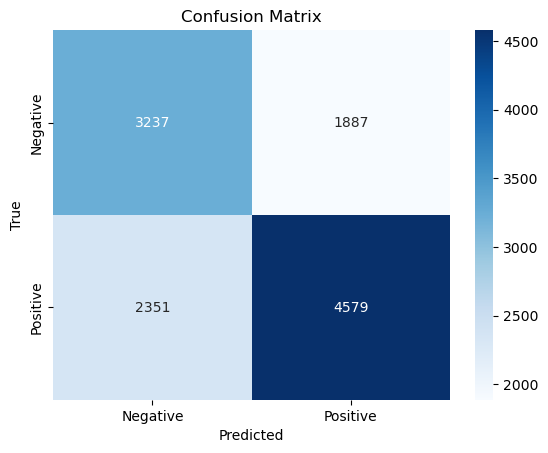

In [9]:
# confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# plot confusion matrix
plot_confusion_matrix(y_test, model_pipeline.predict(X_test))

In [10]:
# Tuning hyperparameters for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear', 'saga']
}
# Create a GridSearchCV object
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)
# Get the best model from grid search
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Day Price', '12m Low',
                                                   '12m High', 'Day Low',
                                                   'Day High', 'Volume',
                                                   'Change', 'Change%']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Code', 'Name',
                                                   'Sector'])])),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x000001CEE9F73C40>)),
                ('pca', PCA(n_components=5)),
                ('classifier',
                 LogisticRegression(C=100, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [11]:
#predict on the test set
y_pred_best = best_model.predict(X_test)
# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))

Best Model Accuracy: 0.6608594657375145


In [12]:
# create a pipeline for the XGBoost model
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('pca', PCA(n_components=5)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [13]:
#fit and evaluate the XGBoost model
train_and_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

Model Accuracy: 0.9644101543056247
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      5124
           1       0.96      0.98      0.97      6930

    accuracy                           0.96     12054
   macro avg       0.97      0.96      0.96     12054
weighted avg       0.96      0.96      0.96     12054

Confusion Matrix:
[[4823  301]
 [ 128 6802]]


Text(0.5, 36.72222222222221, 'Predicted')

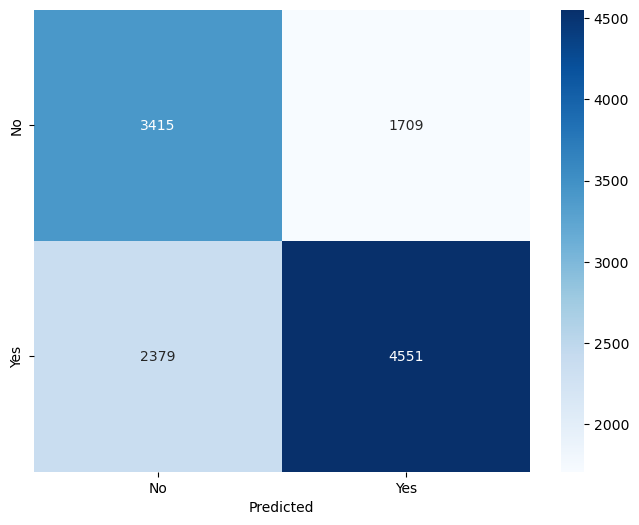

In [14]:
# plot a confusion matrix for the XGBoost model
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')

In [15]:
# Tune hyperparameters for XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Create a GridSearchCV object for XGBoost
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# Fit the grid search to the training data  
xgb_grid_search.fit(X_train, y_train)
# Get the best model from grid search
best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Day Price', '12m Low',
                                                   '12m High', 'Day Low',
                                                   'Day High', 'Volume',
                                                   'Change', 'Change%']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [16]:
# predict on the test set
y_pred_best = best_xgb_model.predict(X_test)
# Evaluate the best XGBoost model
print("Best XGBoost Model Accuracy:", accuracy_score(y_test, y_pred_best))

Best XGBoost Model Accuracy: 0.9702173552347768


In [17]:
# Evaluate the XGBoost model
train_and_evaluate_model(best_xgb_model, X_train, y_train, X_test, y_test)

Model Accuracy: 0.9702173552347768
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5124
           1       0.96      0.98      0.97      6930

    accuracy                           0.97     12054
   macro avg       0.97      0.97      0.97     12054
weighted avg       0.97      0.97      0.97     12054

Confusion Matrix:
[[4870  254]
 [ 105 6825]]


In [18]:
# create a LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50,activation='relu', input_shape=(X_train_pca.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Reshape the input data for LSTM
X_train_lstm = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_lstm = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))
# Fit the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))
# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Model Accuracy: {lstm_accuracy}")

Epoch 1/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.6316 - loss: 0.6030 - val_accuracy: 0.6604 - val_loss: 0.5626
Epoch 2/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6712 - loss: 0.5469 - val_accuracy: 0.6580 - val_loss: 0.5462
Epoch 3/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6707 - loss: 0.5465 - val_accuracy: 0.7229 - val_loss: 0.5332
Epoch 4/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6824 - loss: 0.5389 - val_accuracy: 0.7278 - val_loss: 0.5271
Epoch 5/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6956 - loss: 0.5321 - val_accuracy: 0.7237 - val_loss: 0.5184
Epoch 6/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7034 - loss: 0.5271 - val_accuracy: 0.6204 - val_loss: 0.5494
Epoch 7/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7010 - loss: 0.5234 - val_accuracy: 0.7091 - val_loss: 0.5219
Epoch 8/10
1507/1507 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7008 - loss:

In [19]:
# Tune LSTM hyperparameters
# Keras Tuner or manual grid search. Here, we will just demonstrate a simple approach.
lstm_param_grid = {
    'epochs': [5, 10],
    'batch_size': [16, 32],
    'lstm_units': [30, 60]
}

# fit the LSTM model with different hyperparameters
for epochs in lstm_param_grid['epochs']:
    for batch_size in lstm_param_grid['batch_size']:
        for lstm_units in lstm_param_grid['lstm_units']:
            # Create a new LSTM model with the current hyperparameters
            lstm_model = Sequential()
            lstm_model.add(LSTM(lstm_units, activation='relu', input_shape=(X_train_pca.shape[1], 1)))
            lstm_model.add(Dense(32, activation='relu'))
            lstm_model.add(Dropout(0.6))
            lstm_model.add(Dense(16, activation='relu'))
            lstm_model.add(Dropout(0.5))
            lstm_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
            # Compile the LSTM model
            lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            # Fit the LSTM model
            lstm_model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_lstm, y_test))
# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f"Tuned LSTM Model Accuracy: {lstm_accuracy}")

Epoch 1/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.6137 - loss: 0.6247 - val_accuracy: 0.7287 - val_loss: 0.5439
Epoch 2/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.6643 - loss: 0.5651 - val_accuracy: 0.6629 - val_loss: 0.5284
Epoch 3/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6662 - loss: 0.5516 - val_accuracy: 0.6811 - val_loss: 0.5397
Epoch 4/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.6737 - loss: 0.5480 - val_accuracy: 0.6556 - val_loss: 0.5354
Epoch 5/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6764 - loss: 0.5440 - val_accuracy: 0.6204 - val_loss: 0.5481
Epoch 1/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.6221 - loss: 0.6163 - val_accuracy: 0.6405 - val_loss: 0.5531
Epoch 2/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6698 - loss: 0.5615 - val_accuracy: 0.6639 - val_loss: 0.5419
Epoch 3/5
3014/3014 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6679 - loss: 0.5526 -

In [20]:
# Improve the model by adding more layers or changing the architecture
# use keras tuner

# Define a function to build the LSTM model
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), activation='relu', input_shape=(X_train_pca.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Create a Keras Tuner object
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='lstm_tuning',
    project_name='lstm_hyperparameter_tuning'
)
# Search for the best hyperparameters
tuner.search(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))
# Get the best model
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_model.summary()

Reloading Tuner from lstm_tuning\lstm_hyperparameter_tuning\tuner0.json



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# evaluate the best LSTM model
lstm_loss, lstm_accuracy = best_lstm_model.evaluate(X_test_lstm, y_test)
print(f"Best Tuned LSTM Model Accuracy: {lstm_accuracy}")

377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7736 - loss: 0.4436
Best Tuned LSTM Model Accuracy: 0.772606611251831


In [29]:
# stacked lstm model
# Define a function to build the stacked LSTM model
def build_stacked_lstm_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=50, max_value=200, step=50)
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(X_train_pca.shape[1], 1), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate_1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(lstm_units // 2, activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [31]:
# run the stacked LSTM model with Keras Tuner
tuner_stacked = kt.Hyperband(
    build_stacked_lstm_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='stacked_lstm_tuning',
    project_name='stacked_lstm_hyperparameter_tuning'
)

# Search for the best hyperparameters for the stacked LSTM model
tuner_stacked.search(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))
# Get the best stacked LSTM model
best_stacked_lstm_model = tuner_stacked.get_best_models(num_models=1)[0]
best_stacked_lstm_model.summary()

Trial 30 Complete [00h 03m 36s]
val_accuracy: 0.7693711519241333

Best val_accuracy So Far: 0.7693711519241333
Total elapsed time: 00h 37m 12s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 150)         │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 75)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,076 (621.39 KB)

 Trainable params: 159,076 (621.39 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Evaluate the best stacked LSTM model
stacked_lstm_loss, stacked_lstm_accuracy = best_stacked_lstm_model.evaluate(X_test_lstm, y_test)
print(f"Best Stacked LSTM Model Accuracy: {stacked_lstm_accuracy}")

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7679 - loss: 0.4534
Best Stacked LSTM Model Accuracy: 0.7693711519241333


In [ ]:
# create a pipeline for the best stacked LSTM model
stacked_lstm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('pca', PCA(n_components=5)),
    ('lstm', best_stacked_lstm_model)
])
# Fit and evaluate the best stacked LSTM model
train_and_evaluate_model(stacked_lstm_pipeline, X_train, y_train, X_test, y_test)
# save this pipeline
save_path_stacked = "best_stacked_lstm_model.keras"


In [22]:
# Convolutional Neural Network (CNN) model
# Define a function to build the CNN model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu', input_shape=(X_train_pca.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a Keras Tuner object for CNN
cnn_tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='cnn_tuning',
    project_name='cnn_hyperparameter_tuning'
)

Reloading Tuner from cnn_tuning\cnn_hyperparameter_tuning\tuner0.json


In [23]:
# The cnn model
# Search for the best hyperparameters
cnn_tuner.search(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))
# Get the best model
best_cnn_model = cnn_tuner.get_best_models(num_models=1)[0]
best_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# evaluate the CNN model
cnn_loss, cnn_accuracy = best_cnn_model.evaluate(X_test_lstm, y_test)

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7338 - loss: 0.4959


In [25]:
# print the actual and predicted values
print("Actual values:", y_test.values)
print("Predicted values:", y_pred_best)
print("CNN Model Accuracy:", cnn_accuracy)

Actual values: [1 1 0 ... 1 0 0]
Predicted values: [1 1 0 ... 1 0 0]
CNN Model Accuracy: 0.7346938848495483


In [26]:
# Top ten performing stocks
top_ten_stocks = df.groupby('Name')['Target'].mean().nlargest(10).index.tolist()
print("Top Ten Performing Stocks:", top_ten_stocks)

Top Ten Performing Stocks: ['ABSA NewGold ETF', 'BK Group Plc', 'BOC Kenya Plc', 'Bamburi Cement Ltd', 'British American Tobacco Kenya Plc', 'Diamond Trust Bank Kenya Ltd', 'East African Breweries Ltd', 'Eveready East Africa Ltd', 'Express Kenya Plc', 'I & M Holdings Plc']


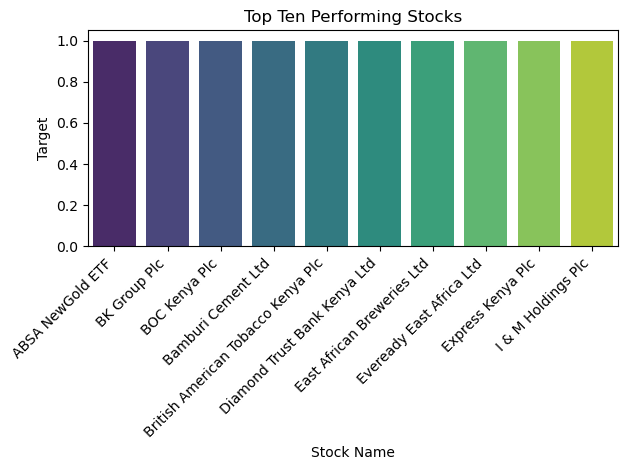

In [28]:
top_ten_df = df[df['Name'].isin(top_ten_stocks)][['Name', 'Target']].groupby('Name').mean().reset_index()
top_ten_df.columns = ['Name', 'Target']
top_ten_df_sorted = top_ten_df.sort_values(by='Target', ascending=False)
sns.barplot(data=top_ten_df_sorted, x='Name', y='Target', palette='viridis')
plt.title('Top Ten Performing Stocks')
plt.xlabel('Stock Name')
plt.ylabel('Target')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
# rename the df to full_df
full_df = df.copy()

#

In [55]:
# save Best XGBoost model
xgb_model_path = "best_xgb_model.pkl"
import joblib
joblib.dump(best_xgb_model, xgb_model_path)

['best_xgb_model.pkl']

In [ ]:
# save the best stacked lstm as keras format
save_path_stacked = "best_stacked_lstm_model.keras"
# Save the best stacked LSTM model in Keras format
best_stacked_lstm_model.save(save_path_stacked)

###  DEPLOYMENT

In [ ]:
# Deploy the model using streamlit
# --- DEPLOYMENT ---
# This section would typically include code to deploy the model using Streamlit or another web framework.
